In [1]:
import numpy as np 
import sys
import os
import matplotlib.pyplot as plt 
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path+"/openmd")
from SimulatorLJ import SimulatorLJ as Simulator


/home/julian/Documents/openmd/openmd


In [15]:

def force_lj_fast( positions, constants, box_length):
    """
    :param positions:
    :type positions:
    :param constants:
    :type constants:
    :param box_length:
    :type box_length:
    :return:
    :rtype:
    """
    
    epsilon, sigma = constants
    num = positions.shape[0]
    force = np.zeros((num, num, 3))
    for i in range(0, num - 1):
        for j in range(i + 1, num):
            ###############
            difference = positions[j, :] - positions[i, :]
            distance = np.linalg.norm(difference)
            if distance > box_length / 2:
                distance -= box_length / 2
            elif distance <= -box_length / 2:
                distance += box_length / 2
            
            #################
            if distance == 0: 
                force[i,j] = 0 
                force[j,i] = 0
                break
            lj_part = (sigma / distance) ** 6
            lj_part_two = lj_part ** 2
            factor = 24 * epsilon
            factor_two = 2 * factor
            force[i, j, :] = (factor_two * lj_part_two - factor * lj_part) * (difference/distance)
            force[j, i, :] -= force[i, j, :]
    #print(np.sum(force, axis=1))
    return np.sum(force, axis=1)

In [16]:
dt = 0.001
positions = np.load("test_samples/test_sample__n_50_s_0.25_eps_0.25_.npy")
velocities = np.zeros(positions.shape)
constants = [1.0, 0.5]
box_length = 6
sim = Simulator(
    path = r"./output",
    title = "test_1",
    mass = 4,
    sim_time= 1000*dt ,
    time_step = dt,
    initial_values = [positions,velocities],
    box_length = box_length,
    force=None,
    force_constants=constants,
    integrator=None,   
    periodic=True,
)
sim.force = force_lj_fast
sim.force

<function __main__.force_lj_fast(positions, constants, box_length)>

In [151]:

def distance_new( positions, constants, box_length):
    """
    :param positions:
    :type positions:
    :param constants:
    :type constants:
    :param box_length:
    :type box_length:
    :return:
    :rtype:
    """
    
    epsilon, sigma = constants
    sigma_six = sigma**6
    prefactor_lj = 24*epsilon*sigma_six
    num = positions.shape[0]
    nvdim = positions.shape[1] # get nvdim for row major writing of matrices 
    position_rm = np.ravel(positions) #row major
    
    dmRM_CPU=np.zeros((num, num),dtype=np.float64,order='C')
    dmRM_CPU = np.ravel(dmRM_CPU)
    FRM_CPU = np.ravel(np.zeros((num, nvdim),dtype=np.float64,order='C'))
    
    
    for i in range(num):
        for j in range(i+1,num):
            dist = 0
            for k in range(nvdim):
                ab = position_rm[i*nvdim + k] - position_rm[j*nvdim + k]
                dist += ab*ab
            temp_dmRM = 1/np.sqrt(dist)
            temp_dmRM2 = temp_dmRM*temp_dmRM
            temp_dmRM6 = temp_dmRM2*temp_dmRM2*temp_dmRM2
            temp_dmRM8 = temp_dmRM6*temp_dmRM2
            for k in range(nvdim):
                ab = position_rm[i*nvdim + k] - position_rm[j*nvdim + k]
                #print(i*num + k)
                FRM_CPU[i*num + k] = (prefactor_lj/temp_dmRM8)*(((2*sigma_six)/temp_dmRM6)-1) * ab
            
    return FRM_CPU

In [152]:
positions = np.random.random((2,3))

In [153]:
%timeit -n 30 distances_new = distance_new( positions, constants, box_length)

35 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [155]:
distances_new = distance_new( positions, constants, box_length)
print(diffdis)


[ 0.3944684   0.          0.         -0.01754702  0.          0.
  0.          0.          0.        ]


In [42]:
positions = np.random.random((3,3))

In [261]:
from numba import njit
@njit()
def force_numba( positions, constants, box_length):
    positions = positions.T
    epsilon, sigma = constants
    sigma_five= sigma**5
    sigma_six = sigma**6
    prefactor_lj = 24*epsilon*sigma_five
    num = positions.shape[1]
    distances_sq = np.zeros((num, num))
    forces = np.zeros((positions.shape[0], num))
    for i in range(0, num - 1):
        for j in range(i + 1, num):
            ###############
            difference = positions[:, j] - positions[:, i]
            distance = np.sqrt(difference[0]**2 + difference[1]**2 + difference[2]**2)
            distance = 1/distance
            distance_sq = distance*distance
            distance_six = distance_sq*distance_sq*distance_sq
            distance_eight = distance_six*distance_sq
            prefactor = prefactor_lj*distance_eight
            bracket = ((2*sigma_six)*distance_six - 1)
            result = prefactor*bracket
            force = result * difference
            forces[:, i] += force
            forces[:, j] -= force 
            #distances_sq[i, j] = inv_dist**2
            
            #distances[j, i] = distance
            
            #if distance > box_length / 2:
            #    distance -= box_length / 2
            #elif distance <= -box_length / 2:
            #    distance += box_length / 2
            
            #################

    return forces.T

In [269]:
constants = [1,1]
positions = np.array([[0,0,0], [1,1, 2]])
distances_old = force_numba( positions, constants, box_length)
print(distances_old)

/home/julian/anaconda3/envs/openmd/lib/python3.10/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'constants' of function 'force_numba'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../tmp/ipykernel_31064/862959087.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[[-0.01834705 -0.01834705 -0.0366941 ]
 [ 0.01834705  0.01834705  0.0366941 ]]


In [270]:
constants = [1,1]
positions = np.array([[0,0,0], [1,0, 0]])
distances_old = force_numba( positions, constants, box_length)
print(distances_old)

[[ 24.   0.   0.]
 [-24.   0.   0.]]


In [264]:
distance = np.sqrt(3)
prefactor = 24/distance**8
bracket = (2/distance**6 - 1)
result = prefactor*bracket
result 

-0.27434842249657077

In [265]:
constants = [1,1]
distances_old = distance_old( positions, constants, box_length)
print(distances_old)

NameError: name 'distance_old' is not defined

In [266]:
positions = np.random.random((1000,3))
%timeit -n 10 distances_old = distance_old( positions, constants, box_length)

NameError: name 'distance_old' is not defined

In [267]:
dt = 0.000002
positions = np.load("test_samples/test_sample__n_128_s_0.25_eps_0.25_.npy")
velocities = np.zeros(positions.shape)
constants = np.array([0.1, 0.1])
box_length = np.int32(8)
sim = Simulator(
    path = r"./output",
    title = "test_1",
    mass = 1,
    sim_time= 10000*dt ,
    time_step = dt,
    initial_values = [positions,velocities],
    box_length = box_length,
    force=None,
    force_constants=constants,
    integrator=None,   
    periodic=True,
)
sim.force = force_numba
sim.force

CPUDispatcher(<function force_numba at 0x7ffa19f50430>)

In [268]:
positions, velocities = sim.simulate()

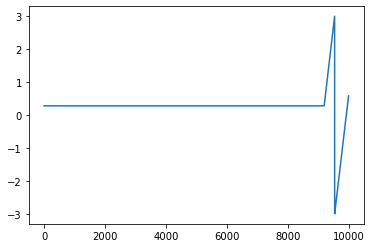

In [9]:
plt.plot(positions[1,1,:].T)

In [223]:
def energy_lj_fast(positions, constants, box_length):
    """Fast energy calculation, e.g. for MC initialization

    Args:
        positions ([type]): [description]
        constants ([type]): [description]
        box_length ([type]): [description]

    Returns:
        [type]: [description]
    """
    epsilon, sigma = constants
    separations = positions[:, None, :] - positions
    # check periodic boundary conditions
    separations[separations > box_length * 0.5] -= box_length
    separations[separations <= -box_length * 0.5] += box_length

    # calculate NxN matrix with distances |r[i] - r[j]|
    # set zero values to None for calculation of acceleration

    ## Replace using CUDA numerics
    distances = np.linalg.norm(separations, axis=-1)
    distances[distances == 0] = None

    # calculate potential energy for Lennard Jones potential
    e_pot = (
        4
        * epsilon
        * (np.power((distances / sigma), -12) - np.power((distances / sigma), -6))
    )
    e_pot[np.isnan(e_pot)] = 0
    
    ## Replace using CUDA numerics
    return np.sum(e_pot)


def kinetic_energy(V, M):
    """Calculates the kinetic energy 

    Args:
        V ([type]): [description]
        M ([type]): [description]
    """

    # normed_vel =np.sum(0.5 * M*V*V,axis=0)
    # assert 1 == 2, str(len(V))
    e_kin = 0
    for i in range(len(V)):
        e_kin += 0.5 * M * np.sum(np.square(V[i, :]))
    return e_kin

In [224]:
energy =[]
e_kin = []
for i in range(positions.shape[2]): 
    energy.append(energy_lj_fast(positions[:,:,i], constants=constants, box_length=box_length))
    e_kin.append(kinetic_energy(velocities[:, :, i], 1))

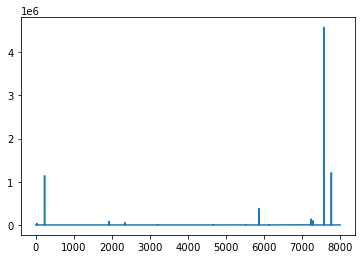

In [226]:
plt.plot(energy[:8000])

In [236]:
# Make more particles 
box_length=4
base = np.load("test_samples/test_sample__n_128_s_0.25_eps_0.25_.npy")
new = base.copy()
tmp = base.copy()
tmp[:,0] = base[:,0]+box_length
new = np.concatenate((tmp, new), axis=0)
tmp = base.copy()
tmp[:,0] = base[:,0]-box_length
new = np.concatenate((tmp, new), axis=0)

In [237]:
print(new.shape)

(384, 3)


In [238]:
base = new.copy()
new = base.copy()
tmp = base.copy()
tmp[:,1] = base[:,1]+box_length
new = np.concatenate((tmp, new), axis=0)
tmp = base.copy()
tmp[:,1] = base[:,1]-box_length
new = np.concatenate((tmp, new), axis=0)
print(new.shape)

(1152, 3)


In [239]:
base = new.copy()
new = base.copy()
tmp = base.copy()
tmp[:,2] = base[:,2]+box_length
new = np.concatenate((tmp, new), axis=0)
tmp = base.copy()
tmp[:,2] = base[:,2]-box_length
new = np.concatenate((tmp, new), axis=0)
print(new.shape)

(3456, 3)


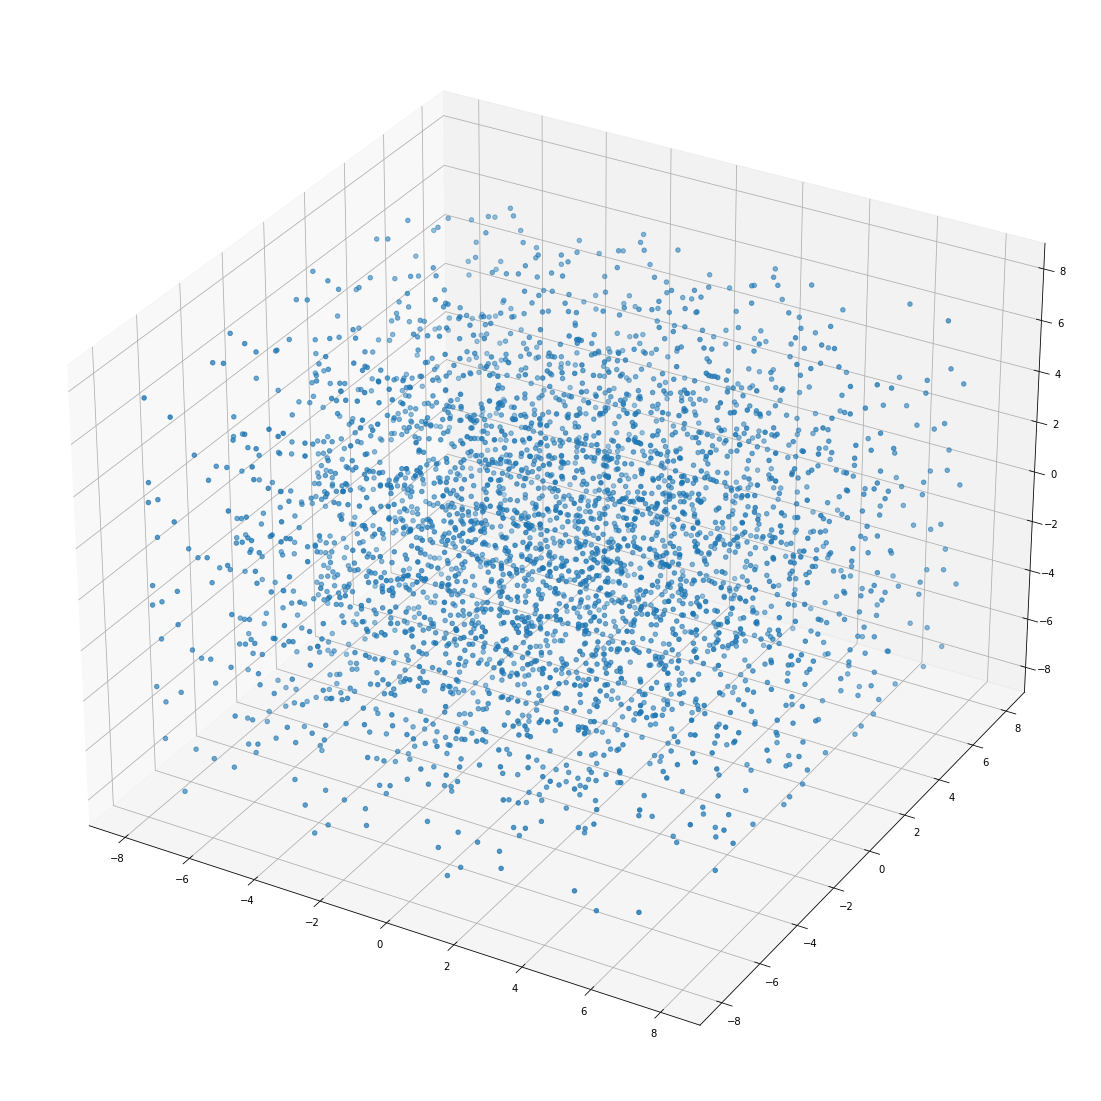

In [251]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(projection='3d')
ax.scatter(new[:,0],new[:,1],new[:,2])

In [244]:
plt.savefig("mc_init_3k.png", dpi = 300)

<Figure size 432x288 with 0 Axes>

In [241]:
dt = 0.0000002
positions = new
velocities = np.zeros(positions.shape)
constants = np.array([0.05, 0.05])
box_length = np.int32(16)
sim = Simulator(
    path = r"./output",
    title = "test_1",
    mass = 1,
    sim_time= 10*dt ,
    time_step = dt,
    initial_values = [positions,velocities],
    box_length = box_length,
    force=None,
    force_constants=constants,
    integrator=None,   
    periodic=True,
)
sim.force = force_numba
sim.force

CPUDispatcher(<function force_numba at 0x7ffa31d56560>)

In [242]:
position, vels = sim.simulate()

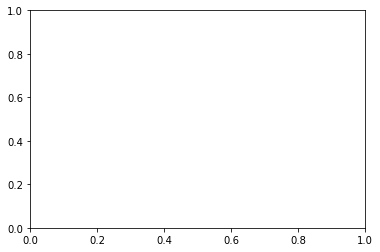

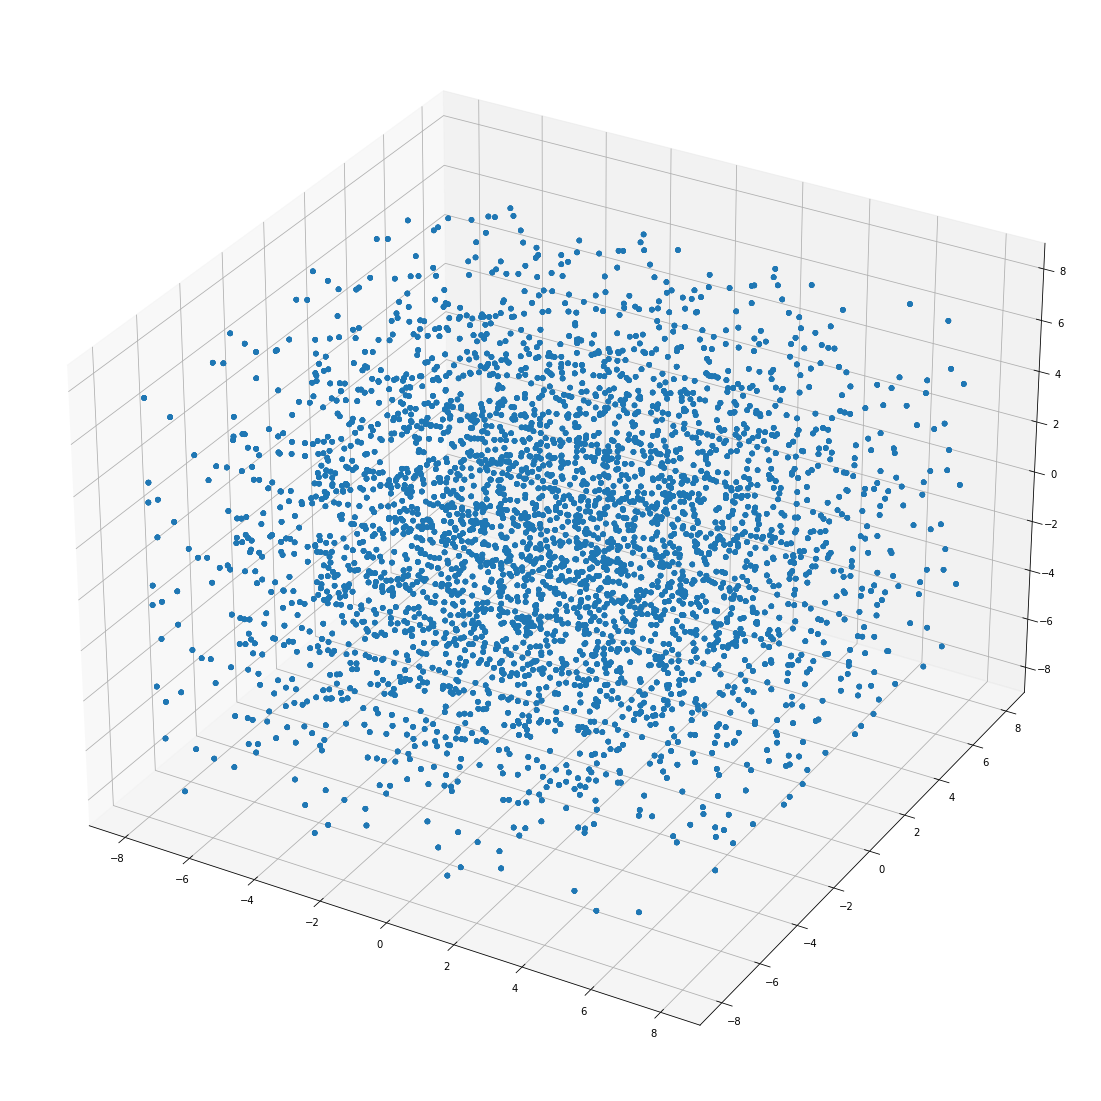

In [252]:
plt.cla()
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(projection='3d')
ax.scatter(position[:,0],position[:,1],position[:,2])

In [250]:
ax.savefig("mc_init_ds_poc.png", dpi = 300)

AttributeError: 'Axes3DSubplot' object has no attribute 'savefig'

In [ ]:
ax.sa